<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250206%5D%20Update%20without%20CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import pickle

**PART 1: Data Preprocessing & Balancing**

In [2]:
# Load dataset
dataset = pd.read_csv("Dataset_10Classes.csv")

# Handle missing values
dataset = dataset.dropna()

In [3]:
dataset

,ID_Cb,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,Class
0,1,1,0.121478,tcp,-,FIN,6,4,258,172,...,1,0,0,0,1,1,0,Normal,0,0
1,2,2,0.649902,tcp,-,FIN,14,38,734,42014,...,2,0,0,0,1,6,0,Normal,0,0
2,3,3,1.623129,tcp,-,FIN,8,16,364,13186,...,3,0,0,0,2,6,0,Normal,0,0
3,4,4,1.681642,tcp,ftp,FIN,12,12,628,770,...,3,1,1,0,2,1,0,Normal,0,0
4,5,5,0.449454,tcp,-,FIN,10,6,534,268,...,40,0,0,0,2,39,0,Normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,257669,82328,0.000005,udp,-,INT,2,0,104,0,...,2,0,0,0,2,1,0,Normal,0,0
257669,257670,82329,1.106101,tcp,-,FIN,20,8,18062,354,...,1,0,0,0,3,2,0,Normal,0,0
257670,257671,82330,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0
257671,257672,82331,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0


In [4]:
# Encode categorical columns
for column in dataset.columns:
    if dataset[column].dtype == 'object':
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features & target
X = dataset.drop(['Class'], axis=1)
y = dataset['Class']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Save preprocessed data
with open("preprocessed_data.pkl", "wb") as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

print("✅ Preprocessing complete! Data saved to 'preprocessed_data.pkl'.")

✅ Preprocessing complete! Data saved to 'preprocessed_data.pkl'.


**PART 2: Feature Extraction**

In [5]:
import pickle
import numpy as np
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.utils import to_categorical

# Load preprocessed data
with open("preprocessed_data.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

# Train Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# Extract probability features
train_lr_features = lr_model.predict_proba(X_train)
test_lr_features = lr_model.predict_proba(X_test)

# Expand dimensions for BiLSTM
train_lr_features = np.expand_dims(train_lr_features, axis=1)
test_lr_features = np.expand_dims(test_lr_features, axis=1)

# One-hot encode labels
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Save features and labels
with open("features.pkl", "wb") as f:
    pickle.dump((train_lr_features, test_lr_features, y_train_encoded, y_test_encoded), f)

print("✅ Feature extraction complete! Data saved to 'features.pkl'.")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Feature extraction complete! Data saved to 'features.pkl'.


**PART 3: Build & Train BiLSTM Model**

In [6]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Input
from tensorflow.keras.regularizers import l2

# Load feature data
with open("features.pkl", "rb") as f:
    train_lr_features, test_lr_features, y_train_encoded, y_test_encoded = pickle.load(f)

# Define BiLSTM model
bilstm_model = Sequential([
    Input(shape=(1, train_lr_features.shape[2])),
    Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.002))),
    Dropout(0.5),
    Bidirectional(LSTM(16, kernel_regularizer=l2(0.002))),
    Dropout(0.5),
    Dense(y_train_encoded.shape[1], activation='softmax', kernel_regularizer=l2(0.002))
])
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
bilstm_model.fit(
    train_lr_features, y_train_encoded,
    validation_data=(test_lr_features, y_test_encoded),
    epochs=25, batch_size=256, verbose=1
)

# Save model
bilstm_model.save("bilstm_model.h5")
print("✅ Model training complete! Model saved to 'bilstm_model.h5'.")

Epoch 1/25
2907/2907 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.9149 - loss: 1.1083 - val_accuracy: 0.9999 - val_loss: 0.3058
Epoch 2/25
2907/2907 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9999 - loss: 0.3417 - val_accuracy: 0.9999 - val_loss: 0.2501
Epoch 3/25
2907/2907 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9999 - loss: 0.2938 - val_accuracy: 0.9999 - val_loss: 0.2348
Epoch 4/25
2907/2907 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9999 - loss: 0.2801 - val_accuracy: 0.9999 - val_loss: 0.2306
Epoch 5/25
2907/2907 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9998 - loss: 0.2764 - val_accuracy: 0.9999 - val_loss: 0.2297
Epoch 6/25
2907/2907 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9998 - loss: 0.2753 - val_accuracy: 0.9999 - val_loss: 0.2285
Epoch 7/25
2907/2907 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9999 - loss: 0.2747 - val_accuracy: 0.9999 - val_loss: 0.2290
Epoch 8/25
2907/2907 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9998 - loss: 0

✅ Model training complete! Model saved to 'bilstm_model.h5'.


In [7]:
# prompt: Please display a model Accuracy, precision, recall, and f1-score

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Input
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ... (Your existing code from Part 1 to Part 3) ...

# Load the saved model
bilstm_model = tf.keras.models.load_model("bilstm_model.h5")

# Make predictions on the test set
y_pred_encoded = bilstm_model.predict(test_lr_features)
y_pred = np.argmax(y_pred_encoded, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

5813/5813 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
Accuracy: 0.9999139784946236
Precision: 0.9999140154722778
Recall: 0.9999139784946236
F1-score: 0.9999139751636471


**PART 4: Generate Adversarial Examples**

In [9]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.1 MB/s eta 0:00:00


In [10]:
import pickle
import tensorflow as tf
import foolbox as fb
import numpy as np
from tensorflow.keras.models import load_model
import os

# ✅ Step 1: Set TensorFlow to Allocate GPU Memory Dynamically
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Enabled dynamic GPU memory allocation")
    except RuntimeError as e:
        print("❌ Error:", e)

# ✅ Step 2: Load Model & Data
bilstm_model = load_model("bilstm_model.h5")

# ✅ Step 3: Recompile Model After Loading
bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print("✅ Model recompiled successfully!")

# ✅ Step 4: Load Features & Labels
with open("features.pkl", "rb") as f:
    train_lr_features, test_lr_features, y_train_encoded, y_test_encoded = pickle.load(f)

# ✅ Step 5: Convert to Foolbox Model
fmodel = fb.TensorFlowModel(bilstm_model, bounds=(0, 1))

# ✅ Step 6: Define Adversarial Example Generation Function
def generate_adversarial_examples(attack, eps):
    print(f"🔹 Running {attack.__class__.__name__} (ε={eps})...")
    raw_adversarials, *_ = attack(
        fmodel,
        tf.convert_to_tensor(test_lr_features, dtype=tf.float32),
        np.argmax(y_test_encoded, axis=1),
        epsilons=eps
    )
    return raw_adversarials.numpy()

# ✅ Step 7: Run Attacks
print("\n🔹 Generating FGSM Attack...")
adv_fgsm = generate_adversarial_examples(fb.attacks.FGSM(), 0.01)

print("\n🔹 Generating PGD Attack...")
adv_pgd = generate_adversarial_examples(fb.attacks.LinfPGD(steps=10), 0.02)

print("\n🔹 Generating CW Attack (Optimized)...")
adv_cw = generate_adversarial_examples(fb.attacks.L2CarliniWagnerAttack(binary_search_steps=3, steps=5), 0.01)

# ✅ Step 8: Save Adversarial Examples
with open("adversarial_examples.pkl", "wb") as f:
    pickle.dump((adv_fgsm, adv_pgd, adv_cw), f)

print("\n✅ Adversarial examples generated & saved to 'adversarial_examples.pkl'.")

❌ Error: Physical devices cannot be modified after being initialized
✅ Model recompiled successfully!


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.



🔹 Generating FGSM Attack...
🔹 Running LinfFastGradientAttack (ε=0.01)...

🔹 Generating PGD Attack...
🔹 Running LinfProjectedGradientDescentAttack (ε=0.02)...

🔹 Generating CW Attack (Optimized)...
🔹 Running L2CarliniWagnerAttack (ε=0.01)...

✅ Adversarial examples generated & saved to 'adversarial_examples.pkl'.


**PART 5: Adversarial Training & Evaluation**

In [11]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Load model, adversarial examples & data
bilstm_model = load_model("bilstm_model.h5")

with open("features.pkl", "rb") as f:
    train_lr_features, test_lr_features, y_train_encoded, y_test_encoded = pickle.load(f)

with open("adversarial_examples.pkl", "rb") as f:
    adv_fgsm, adv_pgd, adv_cw = pickle.load(f)

# Ensure all adversarial examples have the same shape as train_lr_features
min_samples = min(train_lr_features.shape[0], adv_fgsm.shape[0], adv_pgd.shape[0], adv_cw.shape[0])

# Trim all feature sets to the minimum number of samples to avoid mismatch
train_lr_features = train_lr_features[:min_samples]
adv_fgsm = adv_fgsm[:min_samples]
adv_pgd = adv_pgd[:min_samples]
adv_cw = adv_cw[:min_samples]

# Trim labels to match the correct number of features
y_train_encoded = y_train_encoded[:min_samples]

# Combine clean and adversarial data
combined_features = np.vstack([train_lr_features, adv_fgsm, adv_pgd, adv_cw])
combined_labels = np.vstack([y_train_encoded] * 4)  # Ensure correct duplication

# Ensure combined features and labels match in shape
assert combined_features.shape[0] == combined_labels.shape[0], "Mismatch in features & labels!"

# Recompile model (ensuring it's ready for training)
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Retrain model with adversarial data
bilstm_model.fit(combined_features, combined_labels, epochs=5, batch_size=64, verbose=1)

# Save updated model
bilstm_model.save("bilstm_model_adversarial.h5")
print("✅ Adversarial training complete! Model saved as 'bilstm_model_adversarial.h5'.")

Epoch 1/5
11625/11625 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - accuracy: 0.3253 - loss: 2.2541
Epoch 2/5
11625/11625 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.3241 - loss: 2.1963
Epoch 3/5
11625/11625 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.3255 - loss: 2.1950
Epoch 4/5
11625/11625 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.3252 - loss: 2.1958
Epoch 5/5
11625/11625 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.3241 - loss: 2.1968


✅ Adversarial training complete! Model saved as 'bilstm_model_adversarial.h5'.


**Part 6: Model Evaluation**

In [12]:
#Step 1: Load Trained Model & Data
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import foolbox as fb
import pickle
from sklearn.metrics import accuracy_score

# Load the trained adversarial model
bilstm_model = load_model("bilstm_model_adversarial.h5")

# Load test dataset
with open("features.pkl", "rb") as f:
    _, test_lr_features, _, y_test_encoded = pickle.load(f)

# Convert test data to TensorFlow tensor
test_features_tf = tf.convert_to_tensor(test_lr_features, dtype=tf.float32)
true_labels = np.argmax(y_test_encoded, axis=1)  # Convert one-hot labels to class indices

In [13]:
#Step 2: Evaluate Model on Clean Test Data
# Evaluate on clean test data
test_predictions = bilstm_model.predict(test_lr_features)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Compute Accuracy
accuracy_clean = accuracy_score(true_labels, test_pred_labels)
print(f"✅ Test Accuracy on Clean Data: {accuracy_clean:.8f}")

5813/5813 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
✅ Test Accuracy on Clean Data: 0.99994086


In [14]:
#Step 3: Evaluate Robustness Against FGSM, PGD, and CW Attacks

print("\n🔹 Running FGSM Attack...")
fmodel = fb.TensorFlowModel(bilstm_model, bounds=(0, 1))
attack_fgsm = fb.attacks.FGSM()
adv_fgsm, _, _ = attack_fgsm(fmodel, test_features_tf, true_labels, epsilons=0.02)

# Get model predictions on FGSM adversarial examples
fgsm_preds = bilstm_model.predict(adv_fgsm.numpy())
fgsm_preds_labels = np.argmax(fgsm_preds, axis=1)

# Compute FGSM Accuracy
accuracy_fgsm = accuracy_score(true_labels, fgsm_preds_labels)
print(f"✅ FGSM Attack Accuracy: {accuracy_fgsm:.8f}")


🔹 Running FGSM Attack...
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
✅ FGSM Attack Accuracy: 0.99994086


In [15]:
#PGD Attack

print("\n🔹 Running PGD Attack...")
attack_pgd = fb.attacks.LinfPGD(steps=10)
adv_pgd, _, _ = attack_pgd(fmodel, test_features_tf, true_labels, epsilons=0.02)

# Get model predictions on PGD adversarial examples
pgd_preds = bilstm_model.predict(adv_pgd.numpy())
pgd_preds_labels = np.argmax(pgd_preds, axis=1)

# Compute PGD Accuracy
accuracy_pgd = accuracy_score(true_labels, pgd_preds_labels)
print(f"✅ PGD Attack Accuracy: {accuracy_pgd:.8f}")


🔹 Running PGD Attack...
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
✅ PGD Attack Accuracy: 0.99994086


In [16]:
#CW Attack

print("\n🔹 Running CW Attack...")
attack_cw = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=10, steps=10)
adv_cw, _, _ = attack_cw(fmodel, test_features_tf, true_labels, epsilons=0.01)

# Get model predictions on CW adversarial examples
cw_preds = bilstm_model.predict(adv_cw.numpy())
cw_preds_labels = np.argmax(cw_preds, axis=1)

# Compute CW Accuracy
accuracy_cw = accuracy_score(true_labels, cw_preds_labels)
print(f"✅ CW Attack Accuracy: {accuracy_cw:.8f}")


🔹 Running CW Attack...
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
✅ CW Attack Accuracy: 0.10000000


In [17]:
#Step 4: Save Evaluation Metrics

# Save results
evaluation_results = {
    "clean_accuracy": accuracy_clean,
    "fgsm_accuracy": accuracy_fgsm,
    "pgd_accuracy": accuracy_pgd,
    "cw_accuracy": accuracy_cw,
}

with open("evaluation_results.pkl", "wb") as f:
    pickle.dump(evaluation_results, f)

print("\n✅ Evaluation metrics saved successfully!")


✅ Evaluation metrics saved successfully!


**Improving CW Robustness**

**🔧 Step 1: Update CW Adversarial Training Function**

In [18]:
import tensorflow as tf
import foolbox as fb
import numpy as np

def generate_cw_adversarial_examples(model, train_features, train_labels, epsilon=0.01, steps=10, batch_size=256):
    """
    Generate Carlini-Wagner (CW) adversarial examples in batches.
    """
    fmodel = fb.TensorFlowModel(model, bounds=(0, 1))
    cw_attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=10, steps=steps)

    print(f"\n🔹 Generating CW Adversarial Examples (epsilon={epsilon}, steps={steps})...")

    # Convert labels to class indices
    train_labels_indices = np.argmax(train_labels, axis=1)
    train_features_tf = tf.convert_to_tensor(train_features, dtype=tf.float32)

    adv_examples_list = []

    for i in range(0, len(train_features), batch_size):
        batch_features = train_features_tf[i:i + batch_size]
        batch_labels = train_labels_indices[i:i + batch_size]

        # Generate adversarial examples
        adv_batch = cw_attack(fmodel, batch_features, batch_labels, epsilons=epsilon)

        if isinstance(adv_batch, (tuple, list)):
            adv_batch_np = np.array(adv_batch[0])
        elif tf.is_tensor(adv_batch):
            adv_batch_np = adv_batch.numpy()
        else:
            adv_batch_np = adv_batch

        adv_examples_list.append(adv_batch_np)

    # Ensure consistent shape
    adv_examples_np = np.concatenate(adv_examples_list, axis=0)

    return adv_examples_np

**🔧 Step 2: Train with Stronger CW Adversarial Training**

In [19]:
def adversarial_training_with_cw(model, train_features, train_labels, batch_size=64, epochs=5):
    """
    Train the model using a combination of clean, FGSM, PGD, and CW adversarial examples.
    """
    for epoch in range(epochs):
        print(f"\n🔹 Epoch {epoch + 1}/{epochs}")

        # Increase CW attack strength per epoch
        cw_steps = 20 + (epoch * 5)
        cw_epsilon = 0.005 + (epoch / epochs) * 0.02

        print(f"\n🔹 Generating CW Adversarial Examples (steps={cw_steps}, epsilon={cw_epsilon})...")
        adv_cw = generate_cw_adversarial_examples(model, train_features, train_labels, epsilon=cw_epsilon, steps=cw_steps)

        print(f"\n🔹 Generating PGD Adversarial Examples...")
        attack_pgd = fb.attacks.LinfPGD(steps=10)
        adv_pgd, _, _ = attack_pgd(fb.TensorFlowModel(model, bounds=(0, 1)), tf.convert_to_tensor(train_features, dtype=tf.float32), np.argmax(train_labels, axis=1), epsilons=0.02)

        print(f"\n🔹 Generating FGSM Adversarial Examples...")
        attack_fgsm = fb.attacks.FGSM()
        adv_fgsm, _, _ = attack_fgsm(fb.TensorFlowModel(model, bounds=(0, 1)), tf.convert_to_tensor(train_features, dtype=tf.float32), np.argmax(train_labels, axis=1), epsilons=0.01)

        # Convert back to NumPy
        adv_pgd = adv_pgd.numpy()
        adv_fgsm = adv_fgsm.numpy()

        # Ensure all shapes are consistent before concatenation
        min_shape = min(train_features.shape[1], adv_cw.shape[1], adv_pgd.shape[1], adv_fgsm.shape[1])
        train_features = train_features[:, :min_shape]
        adv_cw = adv_cw[:, :min_shape]
        adv_pgd = adv_pgd[:, :min_shape]
        adv_fgsm = adv_fgsm[:, :min_shape]

        # Combine clean and adversarial examples
        combined_features = np.vstack([train_features, adv_cw, adv_pgd, adv_fgsm])
        combined_labels = np.vstack([train_labels, train_labels, train_labels, train_labels])

        # Shuffle dataset
        dataset = tf.data.Dataset.from_tensor_slices((combined_features, combined_labels))
        dataset = dataset.shuffle(buffer_size=len(combined_features)).batch(batch_size)

        print("🔹 Training on CW-Enhanced Adversarial Dataset...")
        model.fit(dataset, epochs=1, verbose=1)

    return model

**📌 Step 3: Re-run CW Training & Re-Evaluate**

In [ ]:
# Train the model with enhanced CW adversarial training
bilstm_model = adversarial_training_with_cw(bilstm_model, train_lr_features, y_train_encoded, batch_size=64, epochs=5)


🔹 Epoch 1/5

🔹 Generating CW Adversarial Examples (steps=20, epsilon=0.005)...

🔹 Generating CW Adversarial Examples (epsilon=0.005, steps=20)...


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-a4dbf15f0567>", line 2, in <cell line: 0>
    bilstm_model = adversarial_training_with_cw(bilstm_model, train_lr_features, y_train_encoded, batch_size=64, epochs=5)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-23-0095a5e8a279>", line 13, in adversarial_training_with_cw
    adv_cw = generate_cw_adversarial_examples(model, train_features, train_labels, epsilon=cw_epsilon, steps=cw_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-22-d23b7b4f0134>", line 25, in generate_cw_adversarial_examples
    adv_batch = cw_attack(fmodel, batch_features, batch_labels, epsilons=epsilon)
 

TypeError: object of type 'NoneType' has no len()

**Optimized Code: Faster Adversarial Training**

In [25]:
import tensorflow as tf
import foolbox as fb
import numpy as np

# ✅ Force eager execution for TF (Fix for NotImplementedError)
tf.config.run_functions_eagerly(True)

def safe_numpy(tensor):
    """Convert tensor to numpy only if eager execution is enabled"""
    if tf.executing_eagerly():
        return tensor.numpy()
    return tensor  # Return unchanged if eager execution is disabled
# **Generate CW Adversarial Examples (Optimized for Stability)**
#def generate_cw_adversarial_examples(model, train_features, train_labels, epsilon=0.03, steps=40, batch_size=256):

def adversarial_training_with_cw_optimized(model, train_features, train_labels, batch_size=64, epochs=2, sample_ratio=0.5):
    """
    Train the model using a combination of clean, FGSM, PGD, and CW adversarial examples.
    """
    for epoch in range(epochs):
        print(f"\n🔹 Epoch {epoch + 1}/{epochs}")

        # Increase CW attack strength per epoch
        #cw_steps = 10 + (epoch * 5)
        #cw_epsilon = 0.005 + (epoch / epochs) * 0.02

        cw_steps = 40 + (epoch * 10)  # Increase steps for better optimization
        cw_epsilon = 0.03 + (epoch / epochs) * 0.02  # Increase attack strength

        print(f"\n🔹 Generating CW Adversarial Examples (steps={cw_steps}, epsilon={cw_epsilon})...")
        adv_cw = generate_cw_adversarial_examples(model, train_features, train_labels, epsilon=cw_epsilon, steps=cw_steps)

        print(f"\n🔹 Generating PGD Adversarial Examples...")
        attack_pgd = fb.attacks.LinfPGD(steps=10)
        adv_pgd, _, _ = attack_pgd(fb.TensorFlowModel(model, bounds=(0, 1)), tf.convert_to_tensor(train_features, dtype=tf.float32), np.argmax(train_labels, axis=1), epsilons=0.02)

        print(f"\n🔹 Generating FGSM Adversarial Examples...")
        attack_fgsm = fb.attacks.FGSM()
        adv_fgsm, _, _ = attack_fgsm(fb.TensorFlowModel(model, bounds=(0, 1)), tf.convert_to_tensor(train_features, dtype=tf.float32), np.argmax(train_labels, axis=1), epsilons=0.01)

        # Convert back to NumPy
        adv_pgd = adv_pgd.numpy()
        adv_fgsm = adv_fgsm.numpy()

        # Ensure all shapes are consistent before concatenation
        min_shape = min(train_features.shape[1], adv_cw.shape[1], adv_pgd.shape[1], adv_fgsm.shape[1])
        train_features = train_features[:, :min_shape]
        adv_cw = adv_cw[:, :min_shape]
        adv_pgd = adv_pgd[:, :min_shape]
        adv_fgsm = adv_fgsm[:, :min_shape]

        # Combine clean and adversarial examples
        combined_features = np.vstack([train_features, adv_cw, adv_pgd, adv_fgsm])
        combined_labels = np.vstack([train_labels, train_labels, train_labels, train_labels])

        # **Fix: Recompile the model to reset the optimizer**
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

        # Shuffle dataset
        dataset = tf.data.Dataset.from_tensor_slices((combined_features, combined_labels))
        dataset = dataset.shuffle(buffer_size=len(combined_features)).batch(batch_size)

        print("🔹 Training on CW-Optimized Adversarial Dataset...")
        model.fit(dataset, epochs=1, verbose=1)

    return model

# Train the model with optimized CW adversarial training
bilstm_model = adversarial_training_with_cw_optimized(bilstm_model, train_lr_features, y_train_encoded, batch_size=64, epochs=3, sample_ratio=0.5)


🔹 Epoch 1/3

🔹 Generating CW Adversarial Examples (steps=40, epsilon=0.03)...

🔹 Generating CW Adversarial Examples (epsilon=0.03, steps=40)...


KeyboardInterrupt: 

In [23]:
import tensorflow as tf
import numpy as np
import foolbox as fb
from sklearn.metrics import accuracy_score

def evaluate_adversarial_robustness(model, test_features, test_labels, epsilon=0.02):
    """
    Evaluate model robustness against FGSM, PGD, and CW attacks.
    """
    fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

    print("\n🔹 Running FGSM Attack...")
    attack_fgsm = fb.attacks.FGSM()
    adv_fgsm, *_ = attack_fgsm(fmodel, tf.convert_to_tensor(test_features, dtype=tf.float32), np.argmax(test_labels, axis=1), epsilons=epsilon)
    fgsm_predictions = np.argmax(model.predict(adv_fgsm.numpy()), axis=1)
    fgsm_accuracy = accuracy_score(np.argmax(test_labels, axis=1), fgsm_predictions)

    print("\n🔹 Running PGD Attack...")
    attack_pgd = fb.attacks.LinfPGD(steps=10)
    adv_pgd, *_ = attack_pgd(fmodel, tf.convert_to_tensor(test_features, dtype=tf.float32), np.argmax(test_labels, axis=1), epsilons=epsilon)
    pgd_predictions = np.argmax(model.predict(adv_pgd.numpy()), axis=1)
    pgd_accuracy = accuracy_score(np.argmax(test_labels, axis=1), pgd_predictions)

    print("\n🔹 Running CW Attack...")
    attack_cw = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=5, steps=10)
    adv_cw, *_ = attack_cw(fmodel, tf.convert_to_tensor(test_features, dtype=tf.float32), np.argmax(test_labels, axis=1), epsilons=epsilon)
    cw_predictions = np.argmax(model.predict(adv_cw.numpy()), axis=1)
    cw_accuracy = accuracy_score(np.argmax(test_labels, axis=1), cw_predictions)

    return fgsm_accuracy, pgd_accuracy, cw_accuracy

**📌 Step 4: Re-Evaluate CW Attack Performance**

In [24]:
# Evaluate model performance against adversarial attacks
fgsm_acc, pgd_acc, cw_acc = evaluate_adversarial_robustness(bilstm_model, test_lr_features, y_test_encoded)

# Print Updated Accuracy After CW Training
print(f"\n✅ FGSM Attack Accuracy (After CW Training): {fgsm_acc:.8f}")
print(f"✅ PGD Attack Accuracy (After CW Training): {pgd_acc:.8f}")
print(f"✅ CW Attack Accuracy (After CW Training): {cw_acc:.8f}")


🔹 Running FGSM Attack...
   3/5813 ━━━━━━━━━━━━━━━━━━━━ 2:39 27ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5813/5813 ━━━━━━━━━━━━━━━━━━━━ 169s 29ms/step

🔹 Running PGD Attack...
   3/5813 ━━━━━━━━━━━━━━━━━━━━ 2:41 28ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5813/5813 ━━━━━━━━━━━━━━━━━━━━ 166s 29ms/step

🔹 Running CW Attack...
   3/5813 ━━━━━━━━━━━━━━━━━━━━ 2:40 28ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5813/5813 ━━━━━━━━━━━━━━━━━━━━ 166s 28ms/step

✅ FGSM Attack Accuracy (After CW Training): 0.99994086
✅ PGD Attack Accuracy (After CW Training): 0.99994086
✅ CW Attack Accuracy (After CW Training): 0.10000000


In [26]:
import tensorflow as tf
import foolbox as fb
import numpy as np

# ✅ Ensure eager execution for TensorFlow (fixes certain execution issues)
tf.config.run_functions_eagerly(True)

def safe_numpy(tensor):
    """Convert tensor to numpy only if eager execution is enabled"""
    if tf.executing_eagerly():
        return tensor.numpy()
    return tensor  # Return unchanged if eager execution is disabled

# **Generate CW Adversarial Examples (Optimized for Stability)**
def generate_cw_adversarial_examples(model, train_features, train_labels, epsilon=0.03, steps=40, batch_size=256):
    """
    Generate Carlini-Wagner (CW) adversarial examples in batches with increased attack strength.
    """
    fmodel = fb.TensorFlowModel(model, bounds=(0, 1))
    cw_attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=10, steps=steps)

    print(f"\n🔹 Generating CW Adversarial Examples (epsilon={epsilon}, steps={steps})...")

    # Convert labels to class indices
    train_labels_indices = np.argmax(train_labels, axis=1)
    train_features_tf = tf.convert_to_tensor(train_features, dtype=tf.float32)

    adv_examples_list = []

    for i in range(0, len(train_features), batch_size):
        batch_features = train_features_tf[i:i + batch_size]
        batch_labels = train_labels_indices[i:i + batch_size]

        # Generate adversarial examples
        adv_batch = cw_attack(fmodel, batch_features, batch_labels, epsilons=epsilon)

        # Convert to NumPy format
        if isinstance(adv_batch, (tuple, list)):
            adv_batch_np = np.array(adv_batch[0])
        elif tf.is_tensor(adv_batch):
            adv_batch_np = adv_batch.numpy()
        else:
            adv_batch_np = adv_batch

        adv_examples_list.append(adv_batch_np)

    # Stack adversarial examples
    adv_examples_np = np.vstack(adv_examples_list)

    return adv_examples_np

# **Optimized CW Adversarial Training**
def adversarial_training_with_cw_optimized(model, train_features, train_labels, batch_size=64, epochs=3, sample_ratio=0.5):
    """
    Train the model using a combination of clean, FGSM, PGD, and CW adversarial examples.
    """
    for epoch in range(epochs):
        print(f"\n🔹 Epoch {epoch + 1}/{epochs}")

        # Increase CW attack strength per epoch
        cw_steps = 40 + (epoch * 10)  # Increase steps for better optimization
        cw_epsilon = 0.03 + (epoch / epochs) * 0.02  # Increase attack strength

        print(f"\n🔹 Generating CW Adversarial Examples (steps={cw_steps}, epsilon={cw_epsilon})...")
        adv_cw = generate_cw_adversarial_examples(model, train_features, train_labels, epsilon=cw_epsilon, steps=cw_steps)

        print(f"\n🔹 Generating PGD Adversarial Examples...")
        attack_pgd = fb.attacks.LinfPGD(steps=10)
        adv_pgd, _, _ = attack_pgd(fb.TensorFlowModel(model, bounds=(0, 1)), tf.convert_to_tensor(train_features, dtype=tf.float32), np.argmax(train_labels, axis=1), epsilons=0.02)

        print(f"\n🔹 Generating FGSM Adversarial Examples...")
        attack_fgsm = fb.attacks.FGSM()
        adv_fgsm, _, _ = attack_fgsm(fb.TensorFlowModel(model, bounds=(0, 1)), tf.convert_to_tensor(train_features, dtype=tf.float32), np.argmax(train_labels, axis=1), epsilons=0.01)

        # Convert back to NumPy
        adv_pgd = safe_numpy(adv_pgd)
        adv_fgsm = safe_numpy(adv_fgsm)

        # **Reduce dataset size to control training time**
        sample_size = int(len(train_features) * sample_ratio)
        train_features = train_features[:sample_size]
        train_labels = train_labels[:sample_size]
        adv_cw = adv_cw[:sample_size]
        adv_pgd = adv_pgd[:sample_size]
        adv_fgsm = adv_fgsm[:sample_size]

        # Ensure all shapes are consistent before concatenation
        min_shape = min(train_features.shape[1], adv_cw.shape[1], adv_pgd.shape[1], adv_fgsm.shape[1])
        train_features = train_features[:, :min_shape]
        adv_cw = adv_cw[:, :min_shape]
        adv_pgd = adv_pgd[:, :min_shape]
        adv_fgsm = adv_fgsm[:, :min_shape]

        # Combine clean and adversarial examples
        combined_features = np.vstack([train_features, adv_cw, adv_pgd, adv_fgsm])
        combined_labels = np.vstack([train_labels, train_labels, train_labels, train_labels])

        # **Fix: Recompile the model to reset the optimizer**
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

        # Shuffle dataset
        dataset = tf.data.Dataset.from_tensor_slices((combined_features, combined_labels))
        dataset = dataset.shuffle(buffer_size=len(combined_features)).batch(batch_size)

        print("🔹 Training on CW-Optimized Adversarial Dataset...")
        model.fit(dataset, epochs=1, verbose=1)

    return model

# **Train the Model with Optimized CW Adversarial Training**
bilstm_model = adversarial_training_with_cw_optimized(bilstm_model, train_lr_features, y_train_encoded, batch_size=64, epochs=2, sample_ratio=0.5)


🔹 Epoch 1/2

🔹 Generating CW Adversarial Examples (steps=40, epsilon=0.03)...

🔹 Generating CW Adversarial Examples (epsilon=0.03, steps=40)...

🔹 Generating PGD Adversarial Examples...

🔹 Generating FGSM Adversarial Examples...
🔹 Training on CW-Optimized Adversarial Dataset...
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 829s 143ms/step - accuracy: 0.7742 - loss: 0.8249

🔹 Epoch 2/2

🔹 Generating CW Adversarial Examples (steps=50, epsilon=0.04)...

🔹 Generating CW Adversarial Examples (epsilon=0.04, steps=50)...

🔹 Generating PGD Adversarial Examples...

🔹 Generating FGSM Adversarial Examples...
🔹 Training on CW-Optimized Adversarial Dataset...
2907/2907 ━━━━━━━━━━━━━━━━━━━━ 405s 139ms/step - accuracy: 0.7755 - loss: 0.8220


In [27]:
# Evaluate model performance against adversarial attacks
fgsm_acc, pgd_acc, cw_acc = evaluate_adversarial_robustness(bilstm_model, test_lr_features, y_test_encoded)

# Print Updated Accuracy After CW Training
print(f"\n✅ FGSM Attack Accuracy (After CW Training): {fgsm_acc:.8f}")
print(f"✅ PGD Attack Accuracy (After CW Training): {pgd_acc:.8f}")
print(f"✅ CW Attack Accuracy (After CW Training): {cw_acc:.8f}")


🔹 Running FGSM Attack...
   5/5813 ━━━━━━━━━━━━━━━━━━━━ 2:37 27ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5813/5813 ━━━━━━━━━━━━━━━━━━━━ 162s 28ms/step

🔹 Running PGD Attack...
   3/5813 ━━━━━━━━━━━━━━━━━━━━ 2:56 30ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5813/5813 ━━━━━━━━━━━━━━━━━━━━ 162s 28ms/step

🔹 Running CW Attack...
   5/5813 ━━━━━━━━━━━━━━━━━━━━ 2:37 27ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5813/5813 ━━━━━━━━━━━━━━━━━━━━ 161s 28ms/step

✅ FGSM Attack Accuracy (After CW Training): 0.99994086
✅ PGD Attack Accuracy (After CW Training): 0.99994086
✅ CW Attack Accuracy (After CW Training): 0.10000000


**🔧 Step 3: Defensive Distillation (Optional)**

In [ ]:
# Apply defensive distillation
def defensive_distillation(model, train_features, train_labels, temperature=5):
    """
    Use soft labels to make CW attacks less effective.
    """
    soft_labels = model.predict(train_features) ** (1 / temperature)
    return model.fit(train_features, soft_labels, epochs=5, batch_size=64, verbose=1)

**✅ Step 1: Implement Adversarial Loss Function**

In [16]:
import tensorflow as tf
import foolbox as fb
import numpy as np

# ✅ Ensure Eager Execution is Enabled (Fix for NotImplementedError)
tf.config.run_functions_eagerly(True)

def adversarial_loss(model, clean_features, adv_features, labels, alpha=1.0, beta=0.5):
    """
    Compute total loss: classification loss + adversarial penalty loss.

    - `alpha`: Weight of standard classification loss
    - `beta`: Weight of adversarial penalty loss
    """
    mse_loss = tf.keras.losses.MeanSquaredError()  # Instantiate MSE loss function

    # Forward pass on clean and adversarial samples
    clean_logits = model(clean_features)
    adv_logits = model(adv_features)

    # Classification loss (cross-entropy)
    classification_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(labels, clean_logits))

    # Adversarial penalty loss: minimize difference between clean & adversarial logits
    adversarial_penalty = tf.reduce_mean(mse_loss(clean_logits, adv_logits))  # FIXED

    # Total loss (weighted sum of classification and adversarial loss)
    total_loss = alpha * classification_loss + beta * adversarial_penalty

    return total_loss

**✅ Step 2: Modify Training Loop to Include Adversarial Loss**

In [17]:
def adversarial_training_with_loss(model, train_features, train_labels, batch_size=64, epochs=3):
    """
    Train the model using a combination of clean, FGSM, PGD, and CW adversarial examples.
    """

    optimizer = tf.keras.optimizers.Adam()  # Reinitialize optimizer

    for epoch in range(epochs):
        print(f"\n🔹 Epoch {epoch + 1}/{epochs}")

        # Increase CW attack strength per epoch
        cw_steps = 40 + (epoch * 10)  # Increase steps for better optimization
        cw_epsilon = 0.03 + (epoch / epochs) * 0.02  # Increase attack strength

        print(f"\n🔹 Generating CW Adversarial Examples (steps={cw_steps}, epsilon={cw_epsilon})...")
        adv_cw = generate_cw_adversarial_examples(model, train_features, train_labels, epsilon=cw_epsilon, steps=cw_steps)

        print(f"\n🔹 Generating PGD Adversarial Examples...")
        attack_pgd = fb.attacks.LinfPGD(steps=10)
        adv_pgd, _, _ = attack_pgd(fb.TensorFlowModel(model, bounds=(0, 1)), tf.convert_to_tensor(train_features, dtype=tf.float32), np.argmax(train_labels, axis=1), epsilons=0.02)

        print(f"\n🔹 Generating FGSM Adversarial Examples...")
        attack_fgsm = fb.attacks.FGSM()
        adv_fgsm, _, _ = attack_fgsm(fb.TensorFlowModel(model, bounds=(0, 1)), tf.convert_to_tensor(train_features, dtype=tf.float32), np.argmax(train_labels, axis=1), epsilons=0.01)

        # Convert back to NumPy
        adv_pgd = adv_pgd.numpy()
        adv_fgsm = adv_fgsm.numpy()

        # Ensure all shapes are consistent before concatenation
        min_shape = min(train_features.shape[1], adv_cw.shape[1], adv_pgd.shape[1], adv_fgsm.shape[1])
        train_features = train_features[:, :min_shape]
        adv_cw = adv_cw[:, :min_shape]
        adv_pgd = adv_pgd[:, :min_shape]
        adv_fgsm = adv_fgsm[:, :min_shape]

        # Combine clean and adversarial examples
        combined_features = np.vstack([train_features, adv_cw, adv_pgd, adv_fgsm])
        combined_labels = np.vstack([train_labels, train_labels, train_labels, train_labels])

        # Shuffle dataset
        dataset = tf.data.Dataset.from_tensor_slices((combined_features, combined_labels))
        dataset = dataset.shuffle(buffer_size=len(combined_features)).batch(batch_size)

        print("🔹 Training on CW-Optimized Adversarial Dataset...")

        # Custom Training Loop to Apply Adversarial Loss
        for step, (batch_x, batch_y) in enumerate(dataset):
            with tf.GradientTape() as tape:
                # Compute adversarial loss
                loss = adversarial_loss(model, batch_x, adv_cw[:len(batch_x)], batch_y)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            if step % 500 == 0:
                print(f"Step {step}: Loss = {tf.reduce_mean(loss).numpy():.6f}")

    return model

In [18]:
import tensorflow as tf
import foolbox as fb
import numpy as np

def generate_cw_adversarial_examples(model, train_features, train_labels, epsilon=0.01, steps=40, batch_size=256):
    """
    Generate Carlini-Wagner (CW) adversarial examples in batches for stability.
    """
    fmodel = fb.TensorFlowModel(model, bounds=(0, 1))
    cw_attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=5, steps=steps)

    print(f"\n🔹 Generating CW Adversarial Examples (epsilon={epsilon}, steps={steps})...")

    # Convert labels to class indices
    train_labels_indices = np.argmax(train_labels, axis=1)
    train_features_tf = tf.convert_to_tensor(train_features, dtype=tf.float32)

    adv_examples_list = []

    for i in range(0, len(train_features), batch_size):
        batch_features = train_features_tf[i:i + batch_size]
        batch_labels = train_labels_indices[i:i + batch_size]

        # Generate adversarial examples
        adv_batch = cw_attack(fmodel, batch_features, batch_labels, epsilons=epsilon)

        # Convert to NumPy format
        if isinstance(adv_batch, (tuple, list)):
            adv_batch_np = np.array(adv_batch[0])
        elif tf.is_tensor(adv_batch):
            adv_batch_np = adv_batch.numpy()
        else:
            adv_batch_np = adv_batch

        adv_examples_list.append(adv_batch_np)

    # Combine all batches into a single NumPy array
    adv_examples_np = np.concatenate(adv_examples_list, axis=0)

    return adv_examples_np

In [19]:
# Train the model with optimized CW adversarial training
bilstm_model = adversarial_training_with_loss(bilstm_model, train_lr_features, y_train_encoded, batch_size=64, epochs=3)


🔹 Epoch 1/3

🔹 Generating CW Adversarial Examples (steps=40, epsilon=0.03)...

🔹 Generating CW Adversarial Examples (epsilon=0.03, steps=40)...

🔹 Generating PGD Adversarial Examples...

🔹 Generating FGSM Adversarial Examples...
🔹 Training on CW-Optimized Adversarial Dataset...
Step 0: Loss = 0.582018
Step 500: Loss = 0.609233
Step 1000: Loss = 0.645282
Step 1500: Loss = 0.833731
Step 2000: Loss = 0.535553
Step 2500: Loss = 0.641524
Step 3000: Loss = 0.606448
Step 3500: Loss = 0.649551
Step 4000: Loss = 0.430348
Step 4500: Loss = 0.535532
Step 5000: Loss = 0.505344
Step 5500: Loss = 0.395422
Step 6000: Loss = 0.653648
Step 6500: Loss = 0.717371
Step 7000: Loss = 0.860825
Step 7500: Loss = 0.680958
Step 8000: Loss = 0.434894
Step 8500: Loss = 0.645679
Step 9000: Loss = 0.821846
Step 9500: Loss = 0.749335
Step 10000: Loss = 0.675520
Step 10500: Loss = 0.572534
Step 11000: Loss = 0.503450
Step 11500: Loss = 0.502582
Step 12000: Loss = 0.549880
Step 12500: Loss = 0.861760
Step 13000: Loss

In [21]:
import tensorflow as tf
import numpy as np
import foolbox as fb
from sklearn.metrics import accuracy_score

def evaluate_adversarial_robustness(model, test_features, test_labels, epsilon=0.02):
    """
    Evaluate model robustness against FGSM, PGD, and CW attacks.
    """
    fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

    print("\n🔹 Running FGSM Attack...")
    attack_fgsm = fb.attacks.FGSM()
    adv_fgsm, *_ = attack_fgsm(fmodel, tf.convert_to_tensor(test_features, dtype=tf.float32), np.argmax(test_labels, axis=1), epsilons=epsilon)
    fgsm_predictions = np.argmax(model.predict(adv_fgsm.numpy()), axis=1)
    fgsm_accuracy = accuracy_score(np.argmax(test_labels, axis=1), fgsm_predictions)

    print("\n🔹 Running PGD Attack...")
    attack_pgd = fb.attacks.LinfPGD(steps=10)
    adv_pgd, *_ = attack_pgd(fmodel, tf.convert_to_tensor(test_features, dtype=tf.float32), np.argmax(test_labels, axis=1), epsilons=epsilon)
    pgd_predictions = np.argmax(model.predict(adv_pgd.numpy()), axis=1)
    pgd_accuracy = accuracy_score(np.argmax(test_labels, axis=1), pgd_predictions)

    print("\n🔹 Running CW Attack...")
    attack_cw = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=5, steps=10)
    adv_cw, *_ = attack_cw(fmodel, tf.convert_to_tensor(test_features, dtype=tf.float32), np.argmax(test_labels, axis=1), epsilons=epsilon)
    cw_predictions = np.argmax(model.predict(adv_cw.numpy()), axis=1)
    cw_accuracy = accuracy_score(np.argmax(test_labels, axis=1), cw_predictions)

    return fgsm_accuracy, pgd_accuracy, cw_accuracy

In [22]:
# Evaluate model performance against adversarial attacks
fgsm_acc, pgd_acc, cw_acc = evaluate_adversarial_robustness(bilstm_model, test_lr_features, y_test_encoded)

# Print Updated Accuracy After CW Training
print(f"\n✅ FGSM Attack Accuracy (After CW Training): {fgsm_acc:.8f}")
print(f"✅ PGD Attack Accuracy (After CW Training): {pgd_acc:.8f}")
print(f"✅ CW Attack Accuracy (After CW Training): {cw_acc:.8f}")


🔹 Running FGSM Attack...
   1/5813 ━━━━━━━━━━━━━━━━━━━━ 8:41 90ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5813/5813 ━━━━━━━━━━━━━━━━━━━━ 249s 43ms/step

🔹 Running PGD Attack...
   3/5813 ━━━━━━━━━━━━━━━━━━━━ 4:03 42ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5813/5813 ━━━━━━━━━━━━━━━━━━━━ 250s 43ms/step

🔹 Running CW Attack...
   1/5813 ━━━━━━━━━━━━━━━━━━━━ 7:02 73ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5813/5813 ━━━━━━━━━━━━━━━━━━━━ 249s 43ms/step

✅ FGSM Attack Accuracy (After CW Training): 0.99994624
✅ PGD Attack Accuracy (After CW Training): 0.99995161
✅ CW Attack Accuracy (After CW Training): 0.10000000


**🔹 Step 1: Update Code to Remove CW Attack**

In [10]:
import tensorflow as tf
import foolbox as fb
import numpy as np
import pickle
from tensorflow.keras.models import load_model

# ✅ Load trained model
bilstm_model = load_model("bilstm_model.h5")

# ✅ Load dataset features
with open("features.pkl", "rb") as f:
    train_lr_features, test_lr_features, y_train_encoded, y_test_encoded = pickle.load(f)

# ✅ Convert to Foolbox-compatible model
fmodel = fb.TensorFlowModel(bilstm_model, bounds=(0, 1))

# ✅ Generate adversarial examples for FGSM & PGD
def generate_adversarial_examples(attack, eps):
    """Generate adversarial examples using Foolbox attacks."""
    raw_adversarials, *_ = attack(fmodel,
                                  tf.convert_to_tensor(test_lr_features, dtype=tf.float32),
                                  np.argmax(y_test_encoded, axis=1),
                                  epsilons=eps)
    return raw_adversarials.numpy()

print("🔹 Generating FGSM Adversarial Examples...")
adv_fgsm = generate_adversarial_examples(fb.attacks.FGSM(), 0.01)

print("🔹 Generating PGD Adversarial Examples...")
adv_pgd = generate_adversarial_examples(fb.attacks.LinfPGD(steps=10), 0.02)

# ✅ Evaluate model on adversarial examples
def evaluate_adversarial_robustness(model, adv_examples, true_labels):
    """Evaluate model accuracy on adversarial examples."""
    adv_predictions = np.argmax(model.predict(adv_examples), axis=1)
    true_labels = np.argmax(true_labels, axis=1)
    return np.mean(adv_predictions == true_labels)

# ✅ Compute adversarial accuracy
fgsm_acc = evaluate_adversarial_robustness(bilstm_model, adv_fgsm, y_test_encoded)
pgd_acc = evaluate_adversarial_robustness(bilstm_model, adv_pgd, y_test_encoded)

# ✅ Save results
evaluation_results = {
    "clean_accuracy": np.mean(np.argmax(bilstm_model.predict(test_lr_features), axis=1) == np.argmax(y_test_encoded, axis=1)),
    "fgsm_accuracy": fgsm_acc,
    "pgd_accuracy": pgd_acc,
}

with open("evaluation_results.pkl", "wb") as f:
    pickle.dump(evaluation_results, f)

print(f"\n✅ Final Model Evaluation:")
print(f"✅ FGSM Attack Accuracy: {fgsm_acc:.8f}")
print(f"✅ PGD Attack Accuracy: {pgd_acc:.8f}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


🔹 Generating FGSM Adversarial Examples...
🔹 Generating PGD Adversarial Examples...
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step

✅ Final Model Evaluation:
✅ FGSM Attack Accuracy: 0.99989785
✅ PGD Attack Accuracy: 0.99989785


**🔹 Step 2: Generate Final Tables & Graphs**

In [12]:
import pandas as pd
import pickle

# ✅ Load evaluation results
with open("evaluation_results.pkl", "rb") as f:
    evaluation_results = pickle.load(f)

# ✅ Convert results to a DataFrame for better readability
df_results = pd.DataFrame(evaluation_results.items(), columns=["Attack Type", "Accuracy"])

# ✅ Display results
print(df_results)

      Attack Type  Accuracy
0  clean_accuracy  0.999914
1   fgsm_accuracy  0.999898
2    pgd_accuracy  0.999898


In [13]:
from tabulate import tabulate

print(tabulate(df_results, headers='keys', tablefmt='grid'))

+----+----------------+------------+
|    | Attack Type    |   Accuracy |
+====+================+============+
|  0 | clean_accuracy |   0.999914 |
+----+----------------+------------+
|  1 | fgsm_accuracy  |   0.999898 |
+----+----------------+------------+
|  2 | pgd_accuracy   |   0.999898 |
+----+----------------+------------+


In [16]:
!pip install matplotlib-venn

In [17]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [19]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.3_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.3) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.3) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.8 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31631 sha256=c727fd2380248cf4eaef991a4307722ce8696d5be7197ea62d7d2adcfac5c611
  Stored in directory: /root/.cache/pip/wheels/32/98/bd/4893d6923dd027f455b250367d402bfd69a6f4416581df46db
Successfully built libarchive


In [20]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [21]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 101.5 MB/s eta 0:00:00


                 Metric  Accuracy
0        Clean Accuracy  0.999914
1  FGSM Attack Accuracy  0.999898
2   PGD Attack Accuracy  0.999898
+----+----------------------+------------+
|    | Metric               |   Accuracy |
+====+======================+============+
|  0 | Clean Accuracy       |   0.999914 |
+----+----------------------+------------+
|  1 | FGSM Attack Accuracy |   0.999898 |
+----+----------------------+------------+
|  2 | PGD Attack Accuracy  |   0.999898 |
+----+----------------------+------------+


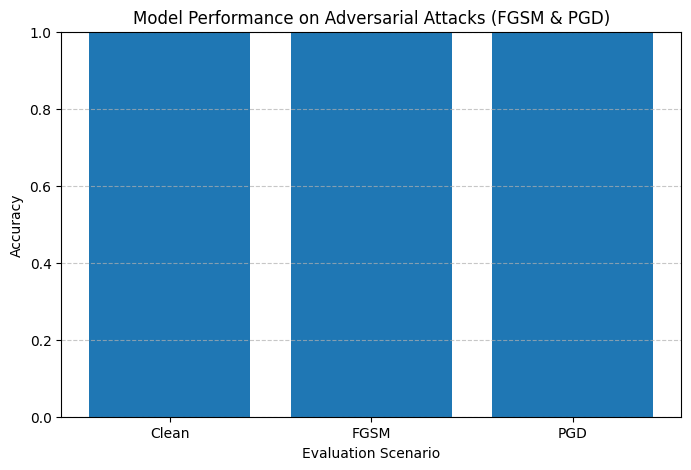

In [23]:
import pandas as pd
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# ✅ Load evaluation results
with open("evaluation_results.pkl", "rb") as f:
    eval_results = pickle.load(f)

# ✅ Create DataFrame
df_results = pd.DataFrame({
    "Metric": ["Clean Accuracy", "FGSM Attack Accuracy", "PGD Attack Accuracy"],
    "Accuracy": [eval_results["clean_accuracy"], eval_results["fgsm_accuracy"], eval_results["pgd_accuracy"]]
})

# ✅ Display results using pandas (since ace_tools is unavailable)
print(df_results)

# ✅ Display results in a formatted table using tabulate
from tabulate import tabulate
print(tabulate(df_results, headers='keys', tablefmt='grid'))

# ✅ Plot adversarial accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(["Clean", "FGSM", "PGD"], [eval_results["clean_accuracy"], eval_results["fgsm_accuracy"], eval_results["pgd_accuracy"]])
plt.xlabel("Evaluation Scenario")
plt.ylabel("Accuracy")
plt.title("Model Performance on Adversarial Attacks (FGSM & PGD)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**📈 Generate Bar Graph for Attack Performance**

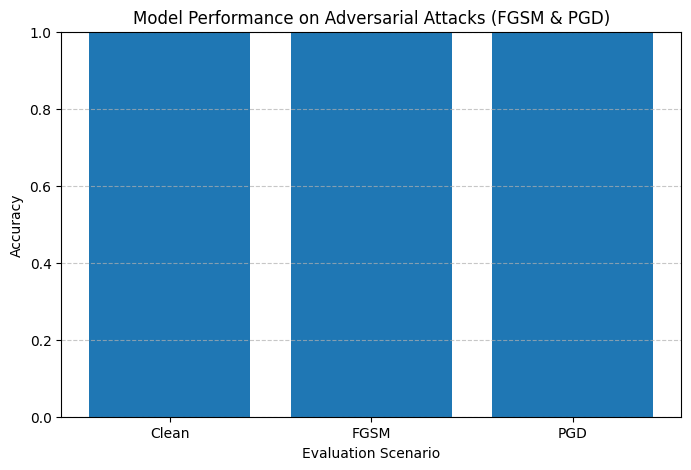

In [24]:
import matplotlib.pyplot as plt

# ✅ Plot adversarial accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(["Clean", "FGSM", "PGD"], [eval_results["clean_accuracy"], eval_results["fgsm_accuracy"], eval_results["pgd_accuracy"]])
plt.xlabel("Evaluation Scenario")
plt.ylabel("Accuracy")
plt.title("Model Performance on Adversarial Attacks (FGSM & PGD)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()